# Employee Performance Clustering (1)

In [1]:
import warnings
import os
warnings.filterwarnings('ignore')

In [2]:
from sklearn.feature_selection     import SelectKBest, f_classif
from feature_engine.outliers       import Winsorizer
from sklearn.model_selection       import train_test_split
from sklearn.preprocessing         import MinMaxScaler, StandardScaler
from sklearn.preprocessing         import LabelEncoder, OrdinalEncoder, OneHotEncoder
from kmodes.kprototypes            import KPrototypes
from sklearn.pipeline              import make_pipeline
from sklearn.compose               import ColumnTransformer
from sklearn.metrics               import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from pyspark.sql                   import SparkSession
from pyforest                      import *

In [4]:
# env
os.environ['HADOOP_HOME']     = r"C:\hadoop"
os.environ['HADOOP_CONF_DIR'] = r"C:\hadoop\etc\hadoop"
os.environ['JAVA_HOME']       = r"C:\Java"  # path jdk


# sesi spark
spark = SparkSession.builder \
    .appName("Hadoop Clustering Performa Karyawan") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://localhost:9000") \
    .config("spark.yarn.stagingDir", "/user/ASUS/.sparkStaging") \
    .getOrCreate()

In [5]:
# data hdfs
hdfs_path   = "/user/ASUS/hadoop_clustering_employee_turnover/HR_Employees.csv"
data_hadoop = spark.read.csv(hdfs_path, header=True, inferSchema=True)

<IPython.core.display.Javascript object>

In [6]:
df          = pd.DataFrame(data_hadoop)

<IPython.core.display.Javascript object>

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tingkat_kepuasan            14999 non-null  float64
 1   evaluasi_terakhir           14999 non-null  float64
 2   jumlah_proyek               14999 non-null  int64  
 3   rata-rata_jam_bulan         14999 non-null  int64  
 4   waktu_spent_for_perusahaan  14999 non-null  int64  
 5   Kecelakaan_kerja            14999 non-null  int64  
 6   resign                      14999 non-null  int64  
 7   promosi_5tahun_terakhir     14999 non-null  int64  
 8   Departemen                  14999 non-null  object 
 9   gaji                        14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [8]:
df.columns

Index(['tingkat_kepuasan', 'evaluasi_terakhir', 'jumlah_proyek',
       'rata-rata_jam_bulan', 'waktu_spent_for_perusahaan', 'Kecelakaan_kerja',
       'resign', 'promosi_5tahun_terakhir', 'Departemen', 'gaji'],
      dtype='object')

In [9]:
df.head(5)

,tingkat_kepuasan,evaluasi_terakhir,jumlah_proyek,rata-rata_jam_bulan,waktu_spent_for_perusahaan,Kecelakaan_kerja,resign,promosi_5tahun_terakhir,Departemen,gaji
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


#### Data Cleaning

In [10]:
df['Departemen'].unique()

array(['sales', 'accounting', 'hr', 'technical', 'support', 'management',
       'IT', 'product_mng', 'marketing', 'RandD'], dtype=object)

one-hot encoding

In [11]:
df['gaji'].unique()

array(['low', 'medium', 'high'], dtype=object)

ordinal encoding with ordinal encoder, manual

In [13]:
df.isnull().sum()

tingkat_kepuasan              0
evaluasi_terakhir             0
jumlah_proyek                 0
rata-rata_jam_bulan           0
waktu_spent_for_perusahaan    0
Kecelakaan_kerja              0
resign                        0
promosi_5tahun_terakhir       0
Departemen                    0
gaji                          0
dtype: int64

In [14]:
df.describe()

,tingkat_kepuasan,evaluasi_terakhir,jumlah_proyek,rata-rata_jam_bulan,waktu_spent_for_perusahaan,Kecelakaan_kerja,resign,promosi_5tahun_terakhir
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [15]:
df.dtypes

tingkat_kepuasan              float64
evaluasi_terakhir             float64
jumlah_proyek                   int64
rata-rata_jam_bulan             int64
waktu_spent_for_perusahaan      int64
Kecelakaan_kerja                int64
resign                          int64
promosi_5tahun_terakhir         int64
Departemen                     object
gaji                           object
dtype: object

In [16]:
for x in df.columns[df.dtypes != np.int64]:
    print(x)
    print(df[x].unique())

<IPython.core.display.Javascript object>

tingkat_kepuasan
[0.38 0.8  0.11 0.72 0.37 0.41 0.1  0.92 0.89 0.42 0.45 0.84 0.36 0.78
 0.76 0.09 0.46 0.4  0.82 0.87 0.57 0.43 0.13 0.44 0.39 0.85 0.81 0.9
 0.74 0.79 0.17 0.24 0.91 0.71 0.86 0.14 0.75 0.7  0.31 0.73 0.83 0.32
 0.54 0.27 0.77 0.88 0.48 0.19 0.6  0.12 0.61 0.33 0.56 0.47 0.28 0.55
 0.53 0.59 0.66 0.25 0.34 0.58 0.51 0.35 0.64 0.5  0.23 0.15 0.49 0.3
 0.63 0.21 0.62 0.29 0.2  0.16 0.65 0.68 0.67 0.22 0.26 0.99 0.98 1.
 0.52 0.93 0.97 0.69 0.94 0.96 0.18 0.95]
evaluasi_terakhir
[0.53 0.86 0.88 0.87 0.52 0.5  0.77 0.85 1.   0.54 0.81 0.92 0.55 0.56
 0.47 0.99 0.51 0.89 0.83 0.95 0.57 0.49 0.46 0.62 0.94 0.48 0.8  0.74
 0.7  0.78 0.91 0.93 0.98 0.97 0.79 0.59 0.84 0.45 0.96 0.68 0.82 0.9
 0.71 0.6  0.65 0.58 0.72 0.67 0.75 0.73 0.63 0.61 0.76 0.66 0.69 0.37
 0.64 0.39 0.41 0.43 0.44 0.36 0.38 0.4  0.42]
Departemen
['sales' 'accounting' 'hr' 'technical' 'support' 'management' 'IT'
 'product_mng' 'marketing' 'RandD']
gaji
['low' 'medium' 'high']


In [17]:
df2                = df.copy()
df2                = df2.drop(columns=['Departemen', 'gaji'])

#### Outlier

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

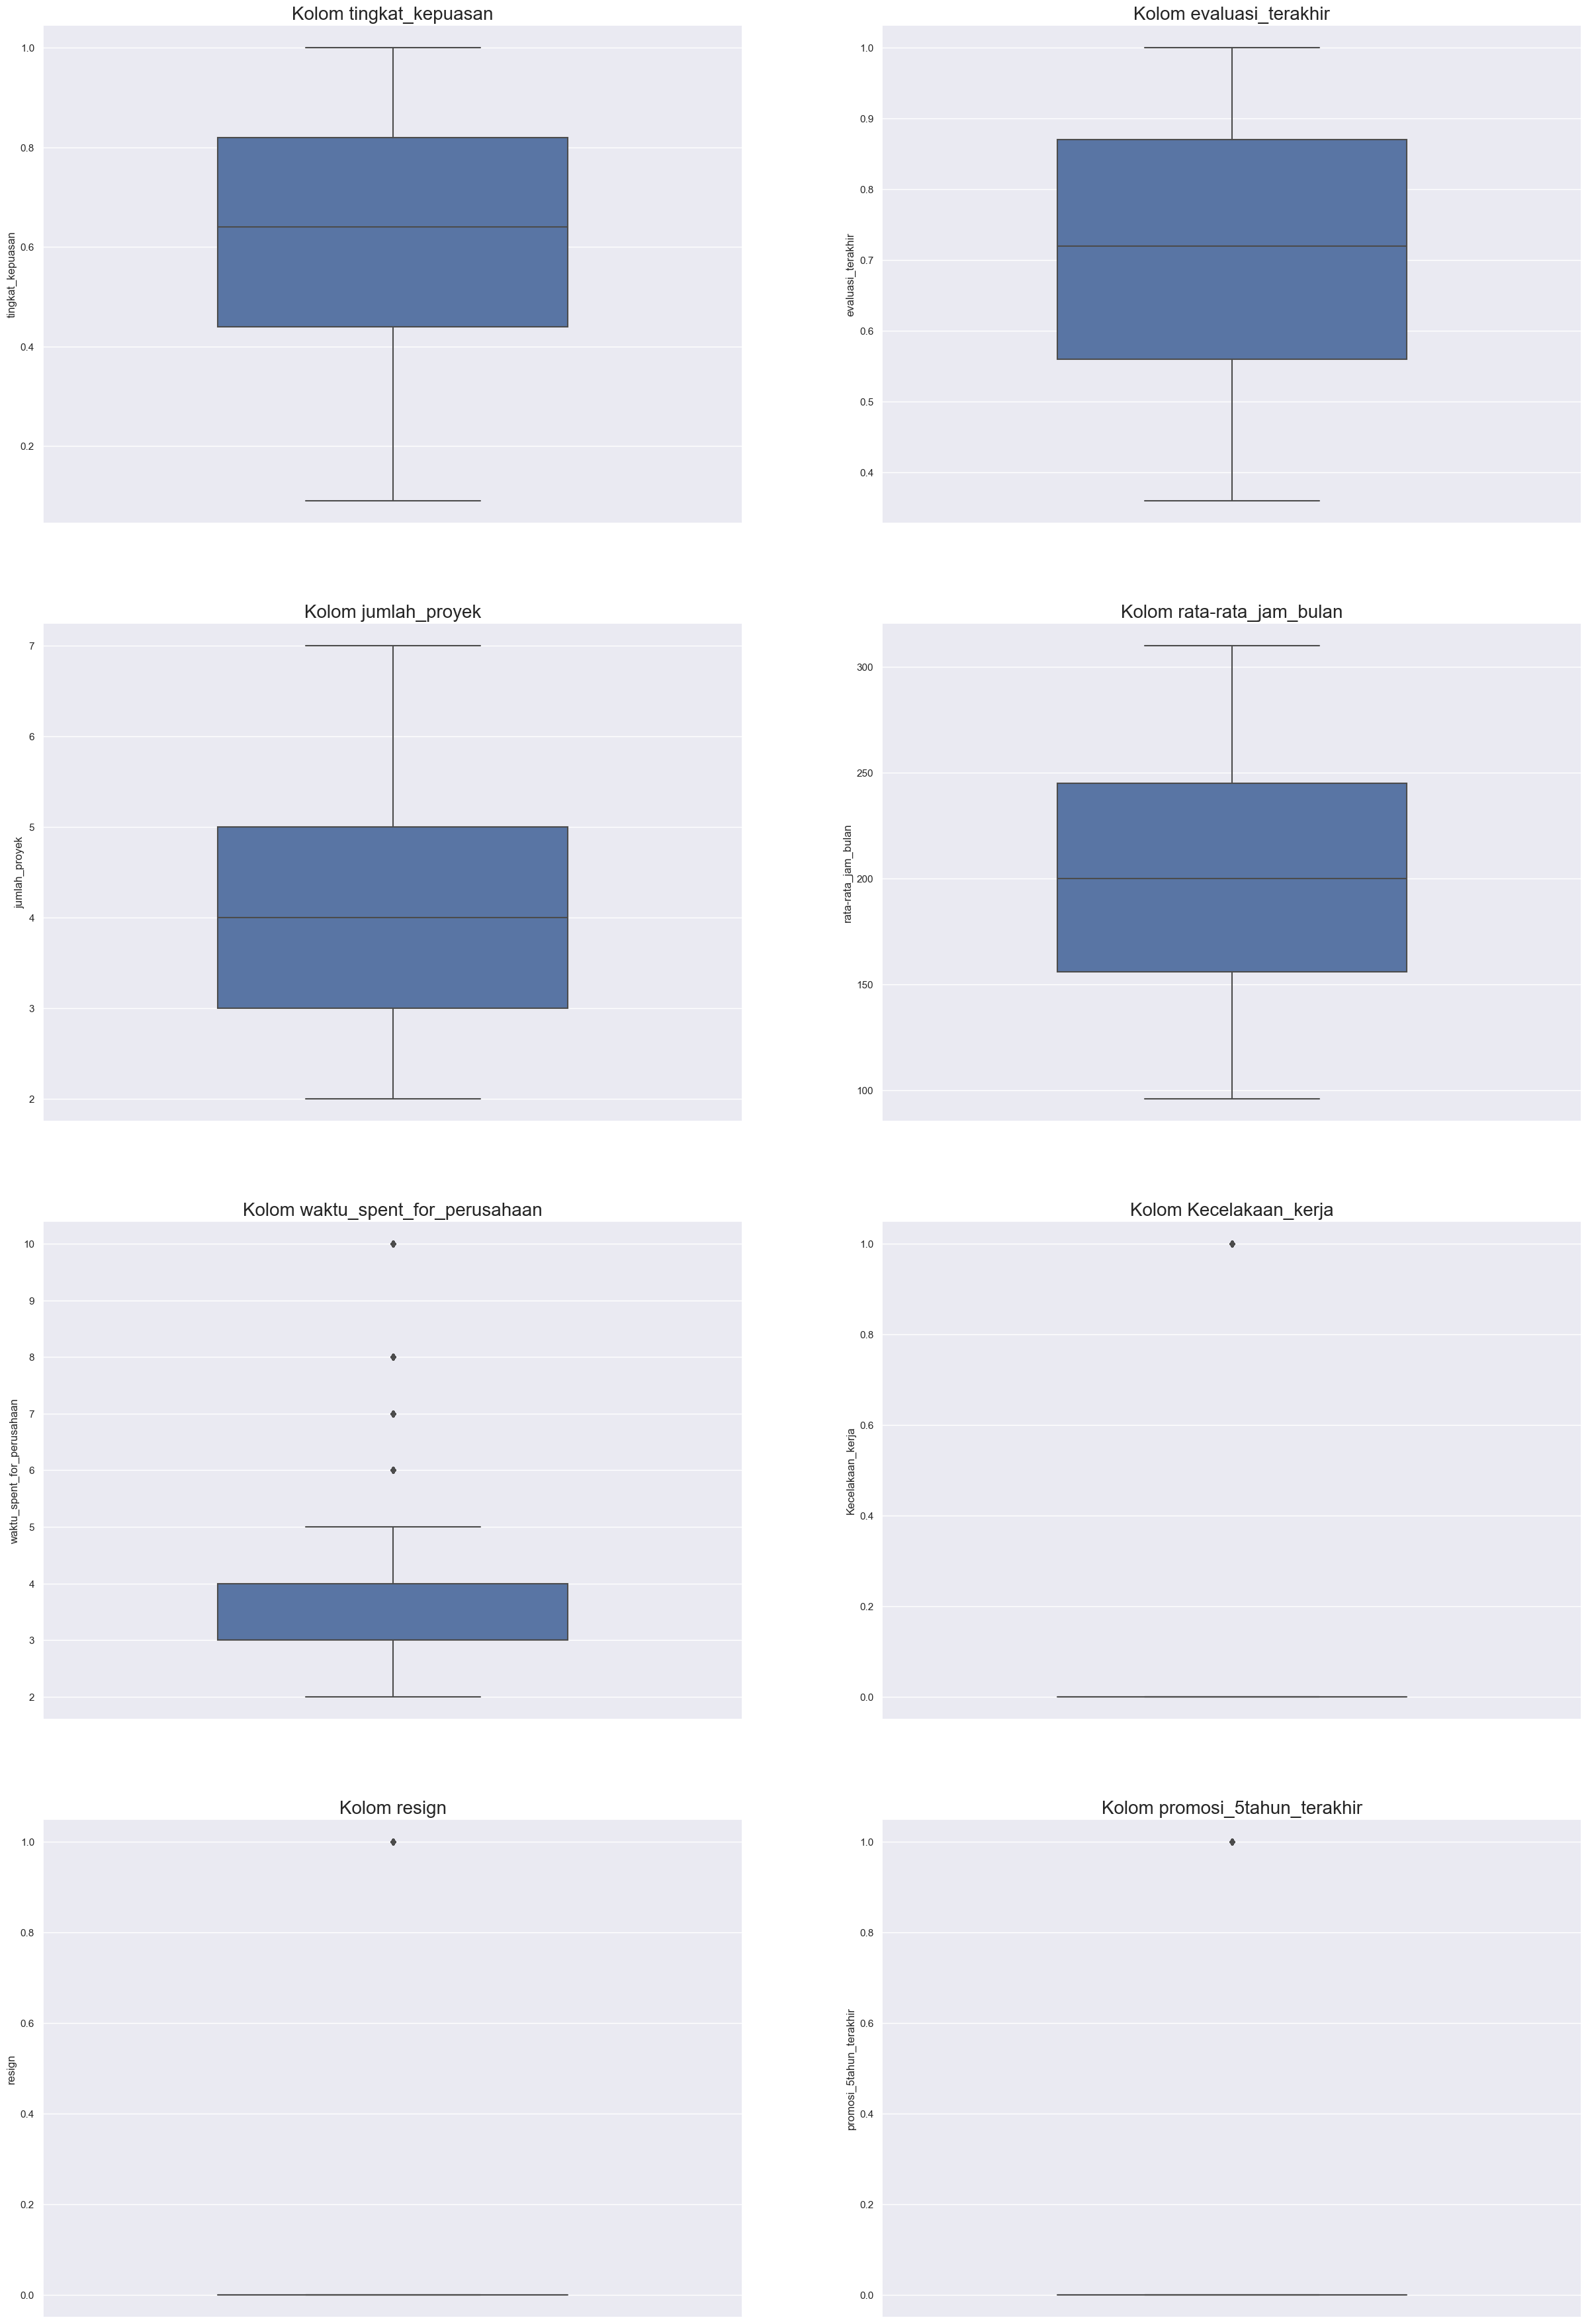

In [18]:
num                = df2
n                  = len(num.columns)
rows               = n // 2
cols               = 2
sns.set(font_scale = 1)
fig, ax            = plt.subplots(rows, cols, figsize=(30, 45))

for i in range(rows):
    
    for j in range(cols):
        
        index      = i * cols + j
        if index   < n:
            col    = num.columns[index]
            sns.boxplot(ax=ax[i, j],
                        data=num,
                        y=num[col],
                        width=0.50)
            
            ax[i, j].set_title(f'Kolom {col}', fontdict={'fontsize': 20})

Sepertinya tidak ada outlier yang signifikan atau perlu ditangani. Seperti kolom waktu_spent_for_perusahaan mungkin datanya yang terkesan ada sedikit outlier itu masih dibutuhkan ya. Karena menunjukkan semakin lama dia betah di suatu perusahaan.

In [19]:
df3 = df.copy()
df3

,tingkat_kepuasan,evaluasi_terakhir,jumlah_proyek,rata-rata_jam_bulan,waktu_spent_for_perusahaan,Kecelakaan_kerja,resign,promosi_5tahun_terakhir,Departemen,gaji
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low


In [20]:
gaji_mapping = {'low': 0, 'medium': 1, 'high': 2}
df3['gaji']  = df3['gaji'].map(gaji_mapping)

In [21]:
df3['gaji'].unique()

array([0, 1, 2], dtype=int64)

In [22]:
df3

,tingkat_kepuasan,evaluasi_terakhir,jumlah_proyek,rata-rata_jam_bulan,waktu_spent_for_perusahaan,Kecelakaan_kerja,resign,promosi_5tahun_terakhir,Departemen,gaji
0,0.38,0.53,2,157,3,0,1,0,sales,0
1,0.80,0.86,5,262,6,0,1,0,sales,1
2,0.11,0.88,7,272,4,0,1,0,sales,1
3,0.72,0.87,5,223,5,0,1,0,sales,0
4,0.37,0.52,2,159,3,0,1,0,sales,0
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,0
14995,0.37,0.48,2,160,3,0,1,0,support,0
14996,0.37,0.53,2,143,3,0,1,0,support,0
14997,0.11,0.96,6,280,4,0,1,0,support,0


In [23]:
df4 = df3.drop(columns=['Departemen'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

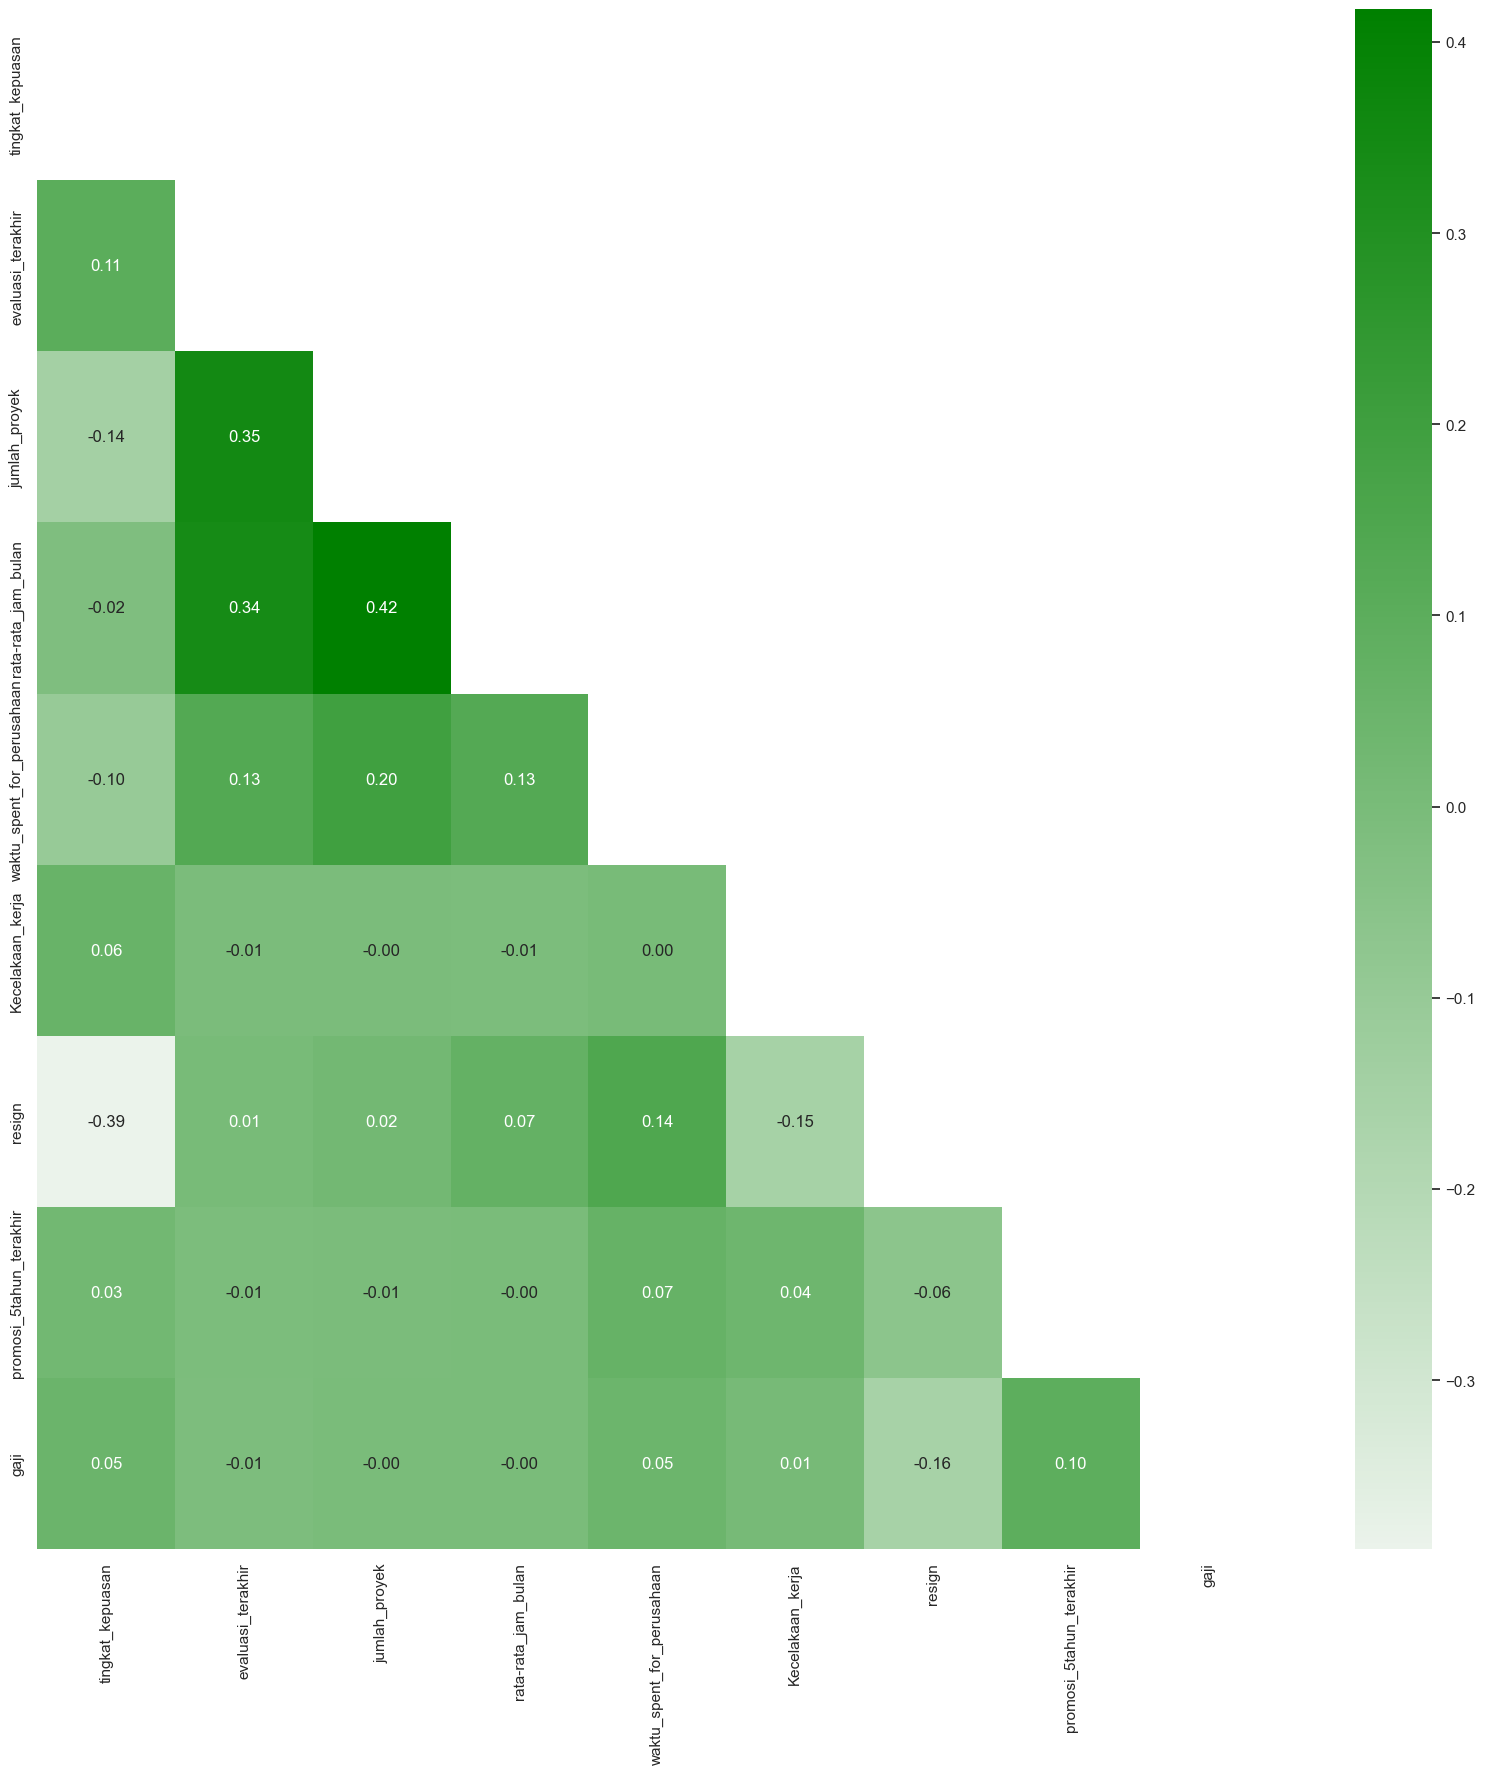

In [24]:
# viz
sns.set(font_scale=1)
plt.figure(figsize=(20, 20))
sns.set_style("white")
cmap = sns.light_palette("green", as_cmap=True)

mask = np.triu(np.ones_like(df4.corr(), dtype=bool))

sns.heatmap(df4.corr(),
            annot=True,
            cmap=cmap,
            fmt='.2f',
            mask=mask)

plt.show()

Hubungan antara jumlah_proyek dan rata-rata_jam_bulan terhadap evaluasi_terakhir memiliki korelasi yang cukup baik. Hal ini berarti nilai skor evaluasi karyawan itu dipengaruhi oleh jumlah proyek yang dijalani dan berapa lama waktu dihabiskan.

Selain itu rata-rata_jam_bulan juga memiliki korelasi yang bagus terhadap jumlah_proyek.

semua fitur diatas sangat diperlukan untuk mencari atau mengelompokkan (cluster). Namun jika untuk modelling terhadap variabel target **resign** mungkin fitur seperti:
- waktu_spent_for_perusahaan
- jumlah_proyek
- rata-rata_jam_bulan
- evaluasi_terakhir
- kecelakaan kerja

In [26]:
df3

,tingkat_kepuasan,evaluasi_terakhir,jumlah_proyek,rata-rata_jam_bulan,waktu_spent_for_perusahaan,Kecelakaan_kerja,resign,promosi_5tahun_terakhir,Departemen,gaji
0,0.38,0.53,2,157,3,0,1,0,sales,0
1,0.80,0.86,5,262,6,0,1,0,sales,1
2,0.11,0.88,7,272,4,0,1,0,sales,1
3,0.72,0.87,5,223,5,0,1,0,sales,0
4,0.37,0.52,2,159,3,0,1,0,sales,0
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,0
14995,0.37,0.48,2,160,3,0,1,0,support,0
14996,0.37,0.53,2,143,3,0,1,0,support,0
14997,0.11,0.96,6,280,4,0,1,0,support,0


In [27]:
df3['Departemen'].unique()

array(['sales', 'accounting', 'hr', 'technical', 'support', 'management',
       'IT', 'product_mng', 'marketing', 'RandD'], dtype=object)

In [28]:
df_depar     = df.copy()
df_depar     = df_depar['Departemen']

In [29]:
df_depar_ril = pd.get_dummies(df_depar, dtype=int)
df_depar_ril

<IPython.core.display.Javascript object>

,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical
0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
14994,0,0,0,0,0,0,0,0,1,0
14995,0,0,0,0,0,0,0,0,1,0
14996,0,0,0,0,0,0,0,0,1,0
14997,0,0,0,0,0,0,0,0,1,0


In [30]:
df3_gabung = pd.concat([df3, df_depar_ril], axis=1)

<IPython.core.display.Javascript object>

In [31]:
df3_gabung

,tingkat_kepuasan,evaluasi_terakhir,jumlah_proyek,rata-rata_jam_bulan,waktu_spent_for_perusahaan,Kecelakaan_kerja,resign,promosi_5tahun_terakhir,Departemen,gaji,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical
0,0.38,0.53,2,157,3,0,1,0,sales,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,sales,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,sales,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,sales,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,sales,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,0,0,0,0,0,0,0,0,0,1,0
14995,0.37,0.48,2,160,3,0,1,0,support,0,0,0,0,0,0,0,0,0,1,0
14996,0.37,0.53,2,143,3,0,1,0,support,0,0,0,0,0,0,0,0,0,1,0
14997,0.11,0.96,6,280,4,0,1,0,support,0,0,0,0,0,0,0,0,0,1,0


In [32]:
df3_gabung.columns

Index(['tingkat_kepuasan', 'evaluasi_terakhir', 'jumlah_proyek',
       'rata-rata_jam_bulan', 'waktu_spent_for_perusahaan', 'Kecelakaan_kerja',
       'resign', 'promosi_5tahun_terakhir', 'Departemen', 'gaji', 'IT',
       'RandD', 'accounting', 'hr', 'management', 'marketing', 'product_mng',
       'sales', 'support', 'technical'],
      dtype='object')

### Clustering
mengelompokkan suatu data menjadi kategori karyawan yang menjelaskan **performa karyawan** seperti apakah dia merupakan karyawan yang kecewa/tidak puas sampai dengan karyawan yang klop/sangat cocok.

Clustering Technique:
1. DBSCAN/HDBSCAN
2. Kmeans

In [33]:
# kategorikal supaya memaksimalkan si kprototype yang mampu clustter terhadap tipe data yang berbeda
posisi_cat = [df3_gabung.columns.get_loc(col) for col in list(df3_gabung.select_dtypes('object').columns)]

print('Categorical columns           : {}'.format(list(df3_gabung.select_dtypes('object').columns)))
print('Categorical columns position  : {}'.format(posisi_cat))

Categorical columns           : ['Departemen']
Categorical columns position  : [8]


In [34]:
df_cluster = df3_gabung.to_numpy()
df_cluster

array([[0.38, 0.53, 2, ..., 1, 0, 0],
       [0.8, 0.86, 5, ..., 1, 0, 0],
       [0.11, 0.88, 7, ..., 1, 0, 0],
       ...,
       [0.37, 0.53, 2, ..., 0, 1, 0],
       [0.11, 0.96, 6, ..., 0, 1, 0],
       [0.37, 0.52, 2, ..., 0, 1, 0]], dtype=object)

- menyiapkan data yang sudah dijadikan array
- mencari k atau tetangga cluster terbaik (akan mencari kesamaan dari k data poin terdekat)

In [35]:
# cat_fitur = ['Departemen']
# cost = []
# k_range = range(1, 11)

# for K in k_range:
#     kproto = KPrototypes(n_clusters=K,
#                         init='Huang',
#                         random_state=42)
    
#     kproto.fit_predict(df_cluster,
#                       categorical=posisi_cat)
#     cost.append(kproto.cost_)
    
# plt.figure(figsize=(10, 8))
# plt.plot(k_range, cost, 'bx-')
# plt.xlabel('Jumlah Cluster (K)')
# plt.ylabel('Cost')
# plt.title('Metode Elbow untuk Menentukan K Optimal')
# plt.show()

metode elbow itu teknik untuk menentukan jumlah cluster (k) optimal dalam algoritma clustering seperti K-Means atau K-Prototypes. lalu menghitung "cost" atau "inertia" yang menunjukkan seberapa baik model tersebut mengelompokkan data.

Berdasarkan hasil asumsi diatas aku bakal pilih jumlah cluster **5** dikarenakan perbedaan antara jumlah cluster 5 dan 6 itu cukup minimal dari segi costnya dibandingkan dengan ketika cluster 4.

In [36]:
posisi_cat = [df3_gabung.columns.get_loc(col) for col in list(df3_gabung.select_dtypes('object').columns)]

k_prototipe = KPrototypes(n_jobs=1,
                          n_clusters=5,
                          init='Huang', #fungsi inisialisasi cukup cepat
                          random_state=0)

k_prototipe.fit_predict(df_cluster, categorical=posisi_cat)

array([2, 3, 3, ..., 4, 3, 2], dtype=uint16)

In [37]:
k_prototipe.cluster_centroids_

array([['0.6805912990196085', '0.7675827205882343', '4.064644607843137',
        '235.16850490196077', '3.645220588235294', '0.14430147058823528',
        '0.21017156862745098', '0.023590686274509803',
        '0.6035539215686274', '0.0784313725490196',
        '0.051470588235294115', '0.045649509803921566',
        '0.0545343137254902', '0.044730392156862746',
        '0.05759803921568627', '0.06158088235294118', '0.28125',
        '0.14154411764705882', '0.18321078431372548', 'sales'],
       ['0.6701683132089303', '0.7204061470911095', '3.77863154043176',
        '198.20087815587266', '3.3457738748627883',
        '0.17819246249542628', '0.022319795096963045',
        '0.020856201975850714', '0.6384924990852543',
        '0.0845225027442371', '0.05561653860226857',
        '0.04427369191364801', '0.045737285034760336',
        '0.050128064398097326', '0.059641419685327476',
        '0.06000731796560556', '0.27332601536772777',
        '0.14233443102817417', '0.18441273326015367', 's

centroid itu pusat dari suatu cluster

In [38]:
# iterasi
k_prototipe.n_iter_

5

In [39]:
k_prototipe.cost_

2004750.9067458985

In [40]:
df3_gabung['cluster'] = k_prototipe.labels_
df3_gabung.head(5)

,tingkat_kepuasan,evaluasi_terakhir,jumlah_proyek,rata-rata_jam_bulan,waktu_spent_for_perusahaan,Kecelakaan_kerja,resign,promosi_5tahun_terakhir,Departemen,gaji,...,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical,cluster
0,0.38,0.53,2,157,3,0,1,0,sales,0,...,0,0,0,0,0,0,1,0,0,2
1,0.80,0.86,5,262,6,0,1,0,sales,1,...,0,0,0,0,0,0,1,0,0,3
2,0.11,0.88,7,272,4,0,1,0,sales,1,...,0,0,0,0,0,0,1,0,0,3
3,0.72,0.87,5,223,5,0,1,0,sales,0,...,0,0,0,0,0,0,1,0,0,0
4,0.37,0.52,2,159,3,0,1,0,sales,0,...,0,0,0,0,0,0,1,0,0,2


In [41]:
df3_gabung['cluster'].unique()

array([2, 3, 0, 4, 1], dtype=uint16)

In [42]:
df3_gabung = df3_gabung.drop(columns=['Departemen'])

In [43]:
df3_gabung.columns

Index(['tingkat_kepuasan', 'evaluasi_terakhir', 'jumlah_proyek',
       'rata-rata_jam_bulan', 'waktu_spent_for_perusahaan', 'Kecelakaan_kerja',
       'resign', 'promosi_5tahun_terakhir', 'gaji', 'IT', 'RandD',
       'accounting', 'hr', 'management', 'marketing', 'product_mng', 'sales',
       'support', 'technical', 'cluster'],
      dtype='object')

In [44]:
df3_gabung['waktu_spent_for_perusahaan'].unique()

array([ 3,  6,  4,  5,  2,  8, 10,  7], dtype=int64)

### Visualisasi

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

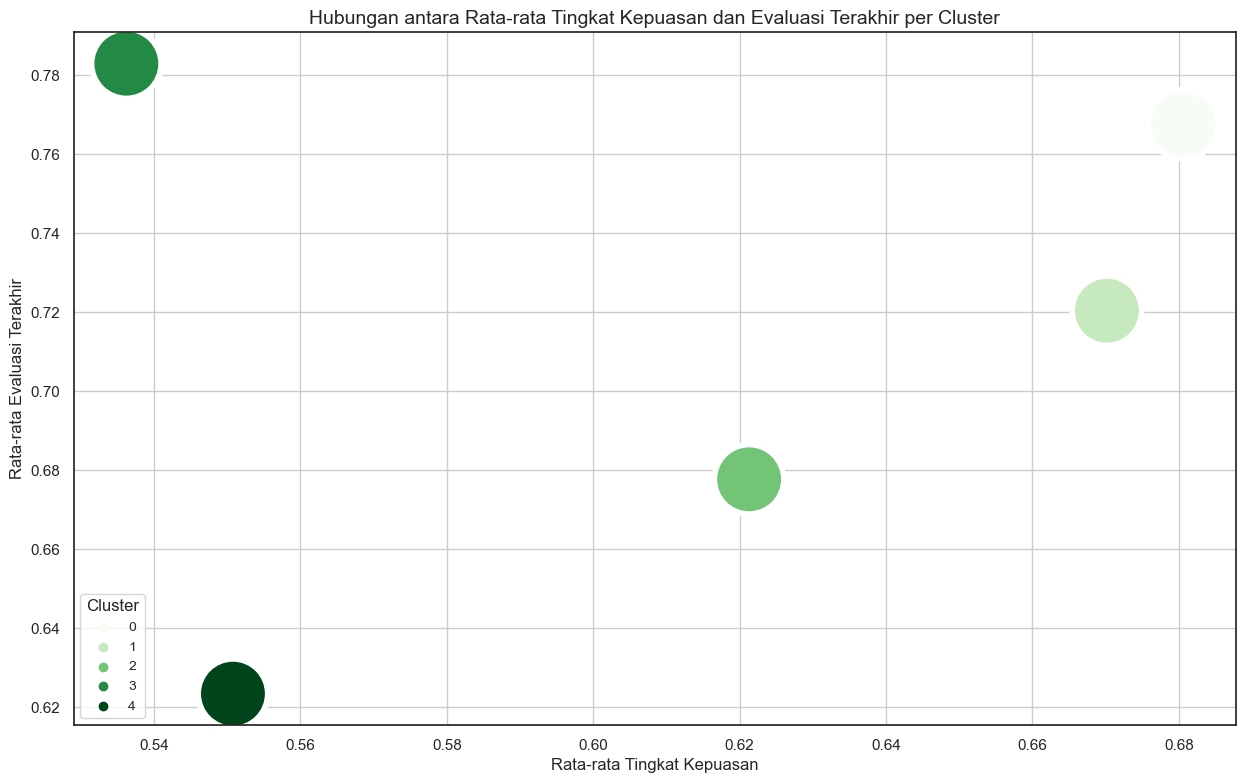

In [45]:
cluster_avg = df3_gabung.groupby('cluster')[['tingkat_kepuasan', 'evaluasi_terakhir']].mean().reset_index()

plt.figure(figsize=(15, 9))
sns.scatterplot(data=cluster_avg,
                x='tingkat_kepuasan',
                y='evaluasi_terakhir',
                hue='cluster', 
                s=2500,
                legend='brief',
                palette='Greens')

plt.title('Hubungan antara Rata-rata Tingkat Kepuasan dan Evaluasi Terakhir per Cluster', fontsize=14)
plt.xlabel('Rata-rata Tingkat Kepuasan', fontsize=12)
plt.ylabel('Rata-rata Evaluasi Terakhir', fontsize=12)
plt.grid(True)
plt.legend(title='Cluster', fontsize=10)
plt.show()

Berdasarkan evaluasi, setiap cluster memiliki karakteristik yang berbeda. Cluster 4 menunjukkan tingkat kepuasan dan evaluasi terakhir yang rendah, mungkin mengindikasikan masalah atau ketidakpuasan. Cluster 3 memiliki tingkat kepuasan terendah, namun evaluasi terakhir tinggi, menunjukkan karyawan mungkin merasa terpaksa meskipun berkinerja tinggi. Cluster 2 menunjukkan keseimbangan antara kepuasan dan kinerja, sementara Cluster 1 dan 0 menunjukkan kepuasan dan kinerja yang semakin tinggi secara berturut-turut. Dengan pemahaman ini, dapat diambil langkah-langkah yang sesuai untuk meningkatkan kepuasan dan kinerja karyawan di setiap cluster.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

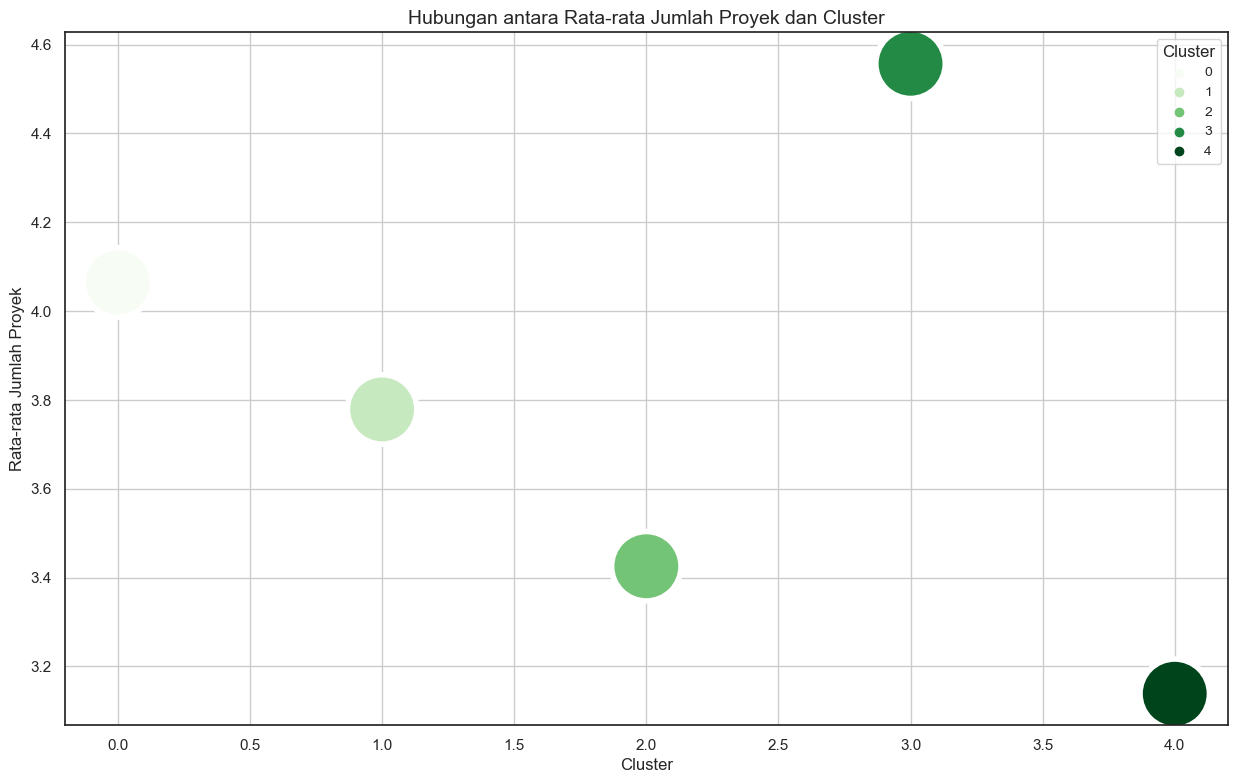

In [46]:
cluster_avg_proyek = df3_gabung.groupby('cluster')['jumlah_proyek'].mean().reset_index()

plt.figure(figsize=(15, 9))
sns.scatterplot(data=cluster_avg_proyek,
                x='cluster',
                y='jumlah_proyek',
                hue='cluster',
                s=2500,
                legend='brief',
                palette='Greens')

plt.title('Hubungan antara Rata-rata Jumlah Proyek dan Cluster', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Rata-rata Jumlah Proyek', fontsize=12)
plt.grid(True)
plt.legend(title='Cluster', fontsize=10)
plt.show()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

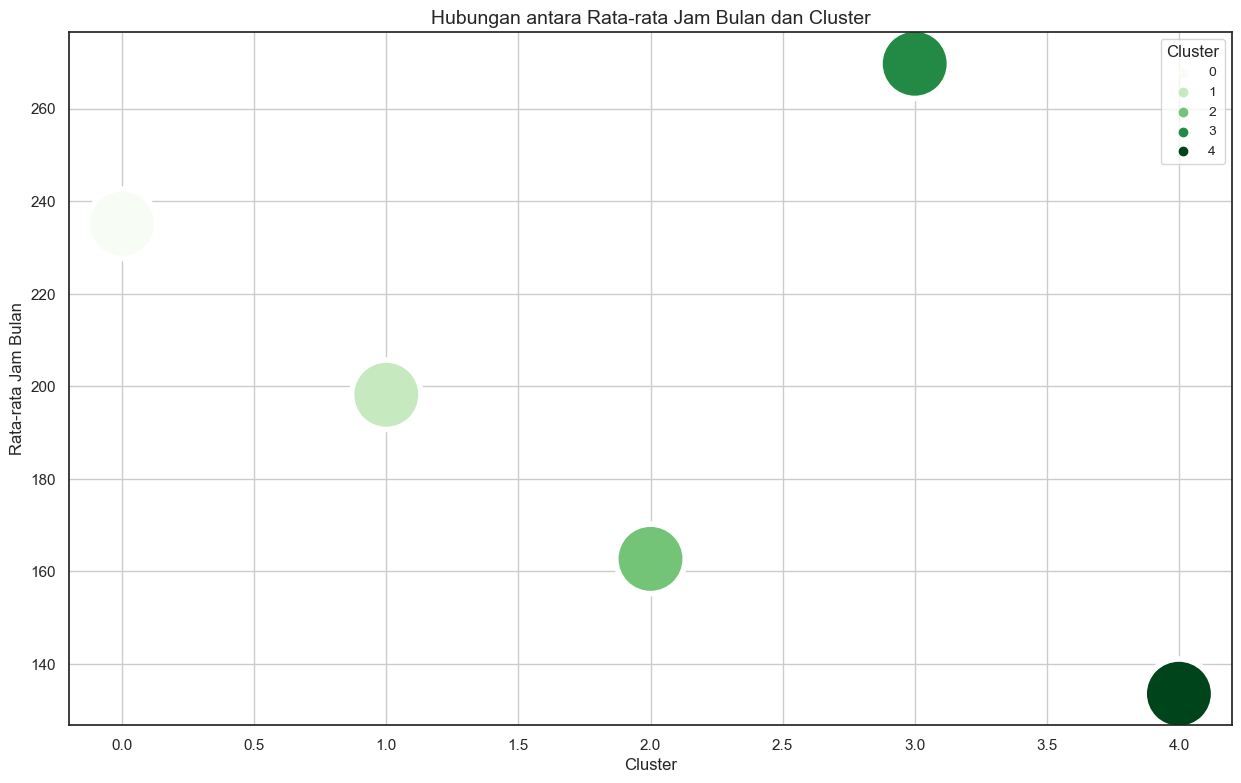

In [47]:
cluster_avg_jam_bulan = df3_gabung.groupby('cluster')['rata-rata_jam_bulan'].mean().reset_index()

plt.figure(figsize=(15, 9))
sns.scatterplot(data=cluster_avg_jam_bulan,
                x='cluster',
                y='rata-rata_jam_bulan',
                hue='cluster',
                s=2500,
                legend='brief',
                palette='Greens')

plt.title('Hubungan antara Rata-rata Jam Bulan dan Cluster', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Rata-rata Jam Bulan', fontsize=12)
plt.grid(True)
plt.legend(title='Cluster', fontsize=10)
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

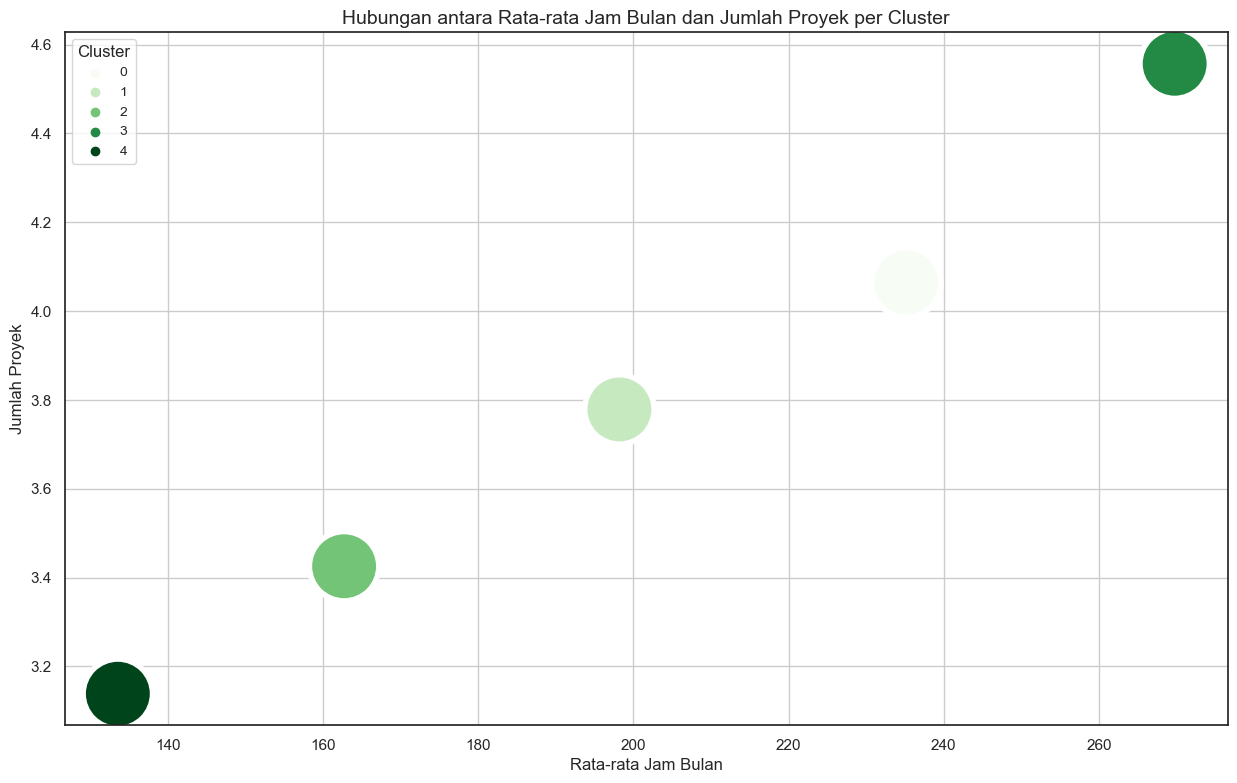

In [48]:
cluster_avg_jam_proyek = df3_gabung.groupby('cluster')[['rata-rata_jam_bulan', 'jumlah_proyek']].mean().reset_index()

plt.figure(figsize=(15, 9))
sns.scatterplot(data=cluster_avg_jam_proyek,
                x='rata-rata_jam_bulan',
                y='jumlah_proyek',
                hue='cluster',
                s=2500,  # rentang ukuran bubble
                legend='brief',
                palette='Greens')

plt.title('Hubungan antara Rata-rata Jam Bulan dan Jumlah Proyek per Cluster', fontsize=14)
plt.xlabel('Rata-rata Jam Bulan', fontsize=12)
plt.ylabel('Jumlah Proyek', fontsize=12)
plt.grid(True)
plt.legend(title='Cluster', fontsize=10)
plt.show()

1. Cluster 4 (**Underperform**) = Karyawan dalam cluster ini cenderung tidak puas dan berkinerja rendah.
2. Cluster 3 (**Overachievers**) = Meskipun tingkat kepuasan rendah, karyawan dalam cluster ini tetap berkinerja tinggi dan mungkin merasa terpaksa.
3. Cluster 2 (**Balanced Performers**) = Karyawan dalam cluster ini menunjukkan keseimbangan antara kepuasan dan kinerja yang baik.
4. Cluster 1 (**Satisfactory Performers**) =  Karyawan dalam cluster ini memiliki tingkat kepuasan dan kinerja yang memadai.
5. Cluster 0 (**High Performers**) = Karyawan dalam cluster ini sangat puas dan berkinerja sangat baik. Hal ini mungkin dia memang baru mendapatkan pekerjaannya

### Analisis Bivariate

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

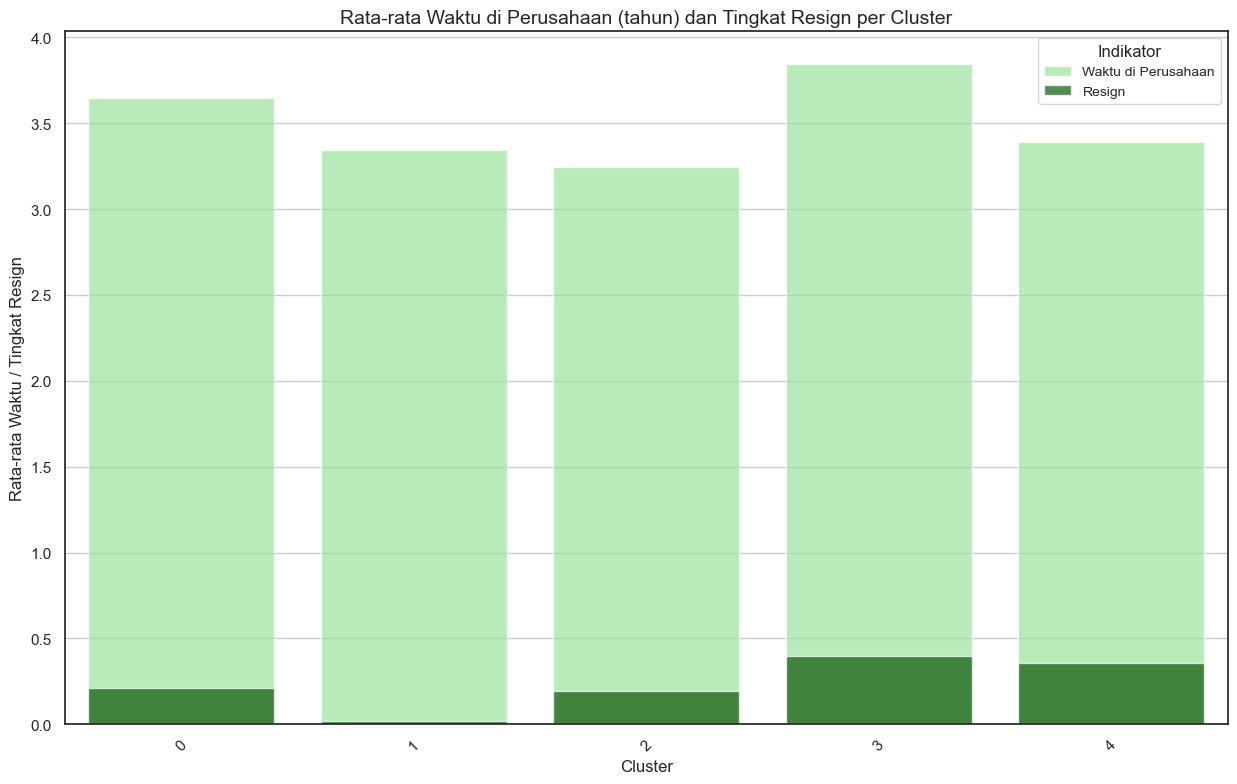

In [54]:
plt.figure(figsize=(15, 9))
sns.barplot(data=cluster_avg_waktu_resign,
            x='cluster',
            y='waktu_spent_for_perusahaan',
            color='lightgreen',
            alpha=0.7,
            label='Waktu di Perusahaan')

sns.barplot(data=cluster_avg_waktu_resign,
            x='cluster',
            y='resign',
            color='darkgreen',
            alpha=0.7,
            label='Resign')

plt.title('Rata-rata Waktu di Perusahaan (tahun) dan Tingkat Resign per Cluster', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Rata-rata Waktu / Tingkat Resign', fontsize=12)
plt.grid(axis='y')
plt.legend(title='Indikator', fontsize=10)
plt.xticks(rotation=45)
plt.show()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

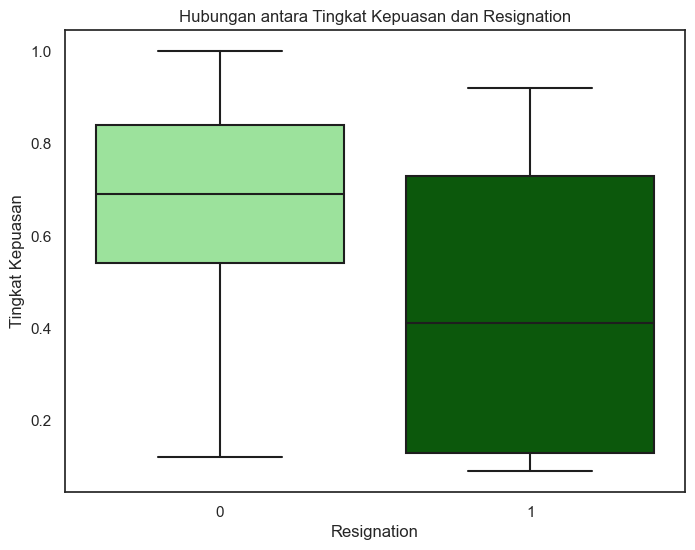

In [55]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='resign', y='tingkat_kepuasan', data=df3_gabung, palette=['lightgreen', 'darkgreen'])
plt.title('Hubungan antara Tingkat Kepuasan dan Resignation')
plt.xlabel('Resignation')
plt.ylabel('Tingkat Kepuasan')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

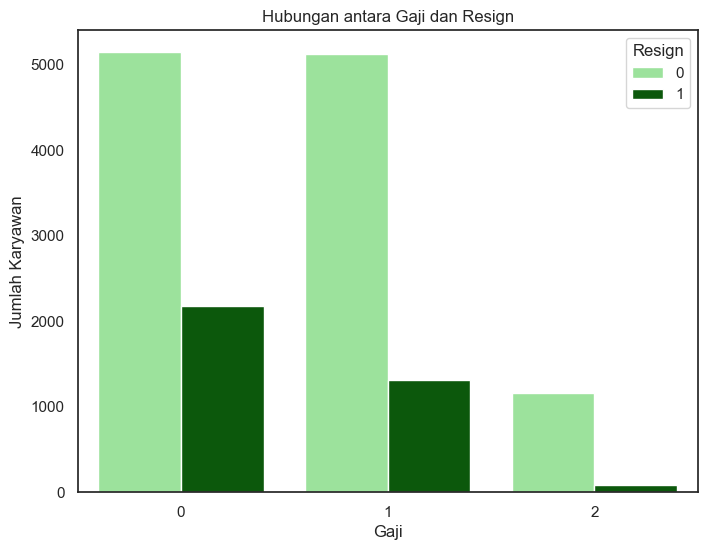

In [56]:
plt.figure(figsize=(8, 6))
sns.countplot(x='gaji', hue='resign', data=df3_gabung, palette=['lightgreen', 'darkgreen'])
plt.title('Hubungan antara Gaji dan Resign')
plt.xlabel('Gaji')
plt.ylabel('Jumlah Karyawan')
plt.legend(title='Resign', loc='upper right')
plt.show()

Semakin tinggi kemungkinan untuk karyawan resign ketika gajinya cukup rendah, begitupun ketika gajinya sedang. 

In [61]:
df3_gabung.write.csv("/user/ASUS/hadoop_clustering_employee_turnover/cluster.csv", header=True)